In [2]:
%load_ext autoreload
%autoreload 2
import os
os.environ["USE_PYGEOS"] = "0"

import h5py
from pathlib import Path
import numpy as np
import pandas as pd
import spatialdata as sd
import scanpy as sc
from scipy.sparse import issparse
# import functions
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
import spatialdata
import spatialdata_plot
import sparrow as sp
import geopandas
import dask_geopandas

/home/chananchidas/miniconda3/envs/napari-sparrow/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/chananchidas/miniconda3/envs/napari-sparrow/lib/python3.10/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)
/home/chananchidas/miniconda3/envs/napari-sparrow/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribut

In [3]:
sdata_polyT = sd.read_zarr('/home/chananchidas/visium-hd/data/vizgen_polyT_45056_solved/')


/home/chananchidas/miniconda3/envs/napari-sparrow/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/tmp/ipykernel_57961/2638059636.py:1: DeprecationWarning: Table group found in zarr store at location /home/chananchidas/visium-hd/data/vizgen_polyT_45056_solved. Please update the zarr store to use tables instead.
  sdata_polyT = sd.read_zarr('/home/chananchidas/visium-hd/data/vizgen_polyT_45056_solved/')


In [9]:
print(sdata_polyT.table.obs['annotation_own_score_genes'].value_counts())
print(sdata_polyT.table.obs['annotation'].value_counts())

annotation_own_score_genes
Hepatocytes          51780
Endothelial cells     8129
Stromal cells         4793
Unknown               4227
Kuppfer cells         3309
Other immunecells     1901
Cholangiocytes        1016
B cells                735
Name: count, dtype: int64
annotation
Hepatocytes                              51813
Endothelial cells                         7273
Stromal cells                             6629
Kuppfer cells                             3400
Cholangiocytes                            2356
ILC1s                                     1487
B cells                                    712
NK cells                                   637
cDC1s                                      531
pDCs                                       313
Monocytes and Monocytes-derived cells      219
Mig. cDCs                                  169
Neutrophils                                107
HsPCs                                      106
cDC2s                                       95
Basophils      

/tmp/ipykernel_11028/2214815381.py:1: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  print(sdata_polyT.table.obs['annotation_own_score_genes'].value_counts())
/tmp/ipykernel_11028/2214815381.py:2: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  print(sdata_polyT.table.obs['annotation'].value_counts())


In [3]:
crd=[10000,15000,8000,12000]

In [11]:
df_spatial = pd.DataFrame(
    sdata_polyT.table.obsm['spatial'], 
    columns=['x', 'y'], 
    index=sdata_polyT.table.obs.index
)

df_spatial['annotation_own_score_genes'] = sdata_polyT.table.obs['annotation_own_score_genes']

df_spatial.to_csv('../data/vizgen_annotation.csv')

/tmp/ipykernel_163706/1313577667.py:2: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  sdata_polyT.table.obsm['spatial'],
/tmp/ipykernel_163706/1313577667.py:4: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  index=sdata_polyT.table.obs.index
/tmp/ipykernel_163706/1313577667.py:7: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  df_spatial['annotation_own_score_genes'] = sdata_polyT.table.obs['annotation_own_score_genes']


In [19]:
# Extract the counts (X) from the AnnData object
counts = sdata_polyT.tables['table'].X

# Convert to a DataFrame for saving as CSV
counts_df = pd.DataFrame(counts, index=sdata_polyT.tables['table'].obs.index, columns=sdata_polyT.tables['table'].var.index)

# Save to CSV
counts_df.to_csv('../data/vizgen_polyT_counts.csv')

#### Print segmentation boundaries

In [6]:
crd=[9000,16000,7000,13000]
sdata_small = sdata_polyT.query.bounding_box(
    min_coordinate=[crd[0], crd[2]], max_coordinate=[crd[1], crd[3]], axes=("x", "y"), target_coordinate_system="global"
)

/home/chananchidas/miniconda3/envs/napari-sparrow/lib/python3.10/functools.py:889: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)


In [1]:
bin_size = 4
sdata_small.pl.render_shapes("to_plot_napari", color="#A6CEE3", outline_alpha=1, outline_color="#1F78B4").pl.show(coordinate_systems="global", figsize=(10, 10))

NameError: name 'sdata_small' is not defined

In [8]:
from shapely.affinity import scale

# Flip the y-coordinates of the geometries in the segmentation_mask_boundaries
flipped_segmentation = sdata_small.shapes['segmentation_mask_boundaries']['geometry'].apply(
    lambda geom: scale(geom, xfact=1, yfact=-1, origin=(0, 0))
)

# Save the flipped geometries to a file
flipped_segmentation.to_file('../rds/vizgen_segmentation_mask_boundaries_roi9-16-7-13.shp')

/home/chananchidas/miniconda3/envs/napari-sparrow/lib/python3.10/site-packages/pyogrio/geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [8]:
adata = sdata_polyT.tables['table']

In [ ]:
sc.tl.leiden(adata, key_added='leiden_0.3', resolution=0.3)

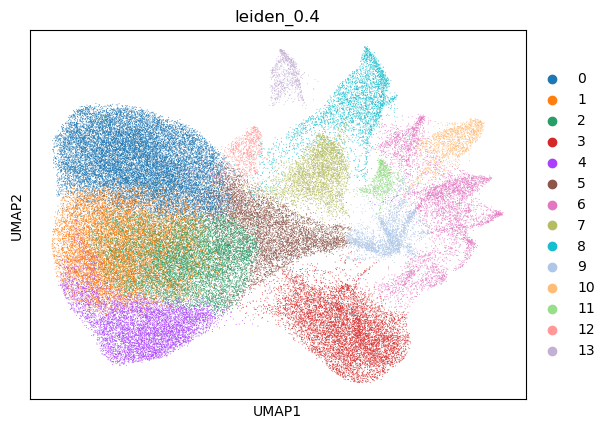

In [ ]:
sc.pl.umap(adata, color=['leiden_0.3'])

In [17]:
output_file_path = f"../rds/vizgen_leiden_clusters.csv"
adata.obs[['leiden_0.4', 'leiden_0.5']].to_csv(output_file_path)